<h1 align="center"><font size="6"> Les méthodes de descente de gradient </font> (deuxième partie)</h1>
<hr> 

<h1>Table des matières</h1>

<div class="alert alert-block alert-info" style="margin-top : 20px">
      <ul>
          <li><a href="#prelim">Préliminaires</a></li>
          <li><a href="#Newton">La méthode de Newton</a></li>
          <li><a href="#BFGS">Une méthode de quasi-Newton (BFGS)</a></li>
      </ul>
</div>
<br>
<h>

<a id='prelim'></a>
<h2>Préliminaires</h2>
<hr>

On commence par importer les bibliothèques neecéssaires (_numpy_ et _matplotlib.pyplot_).

On définit aussi deux functions pour la visualisation de: *1/* les lignes de niveaux de la fonction ojectif et *2/* le champ de gradients (pour les fonctions objectifs dépendant de deux variables). 

Il y a aussi un exemple de graphique pour observer la vitesse de convergence des méthodes d'optimisation.

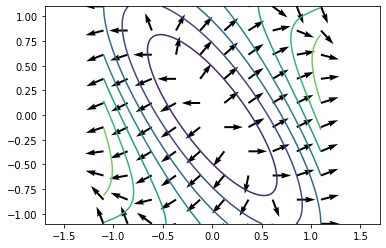

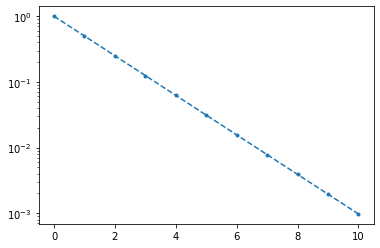

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D

def draw_vector_field(F, xmin, xmax, ymin, ymax, N=15):
    X = np.linspace(xmin, xmax, N)  # x coordinates of the grid points
    Y = np.linspace(ymin, ymax, N)  # y coordinates of the grid points
    U, V = F(*np.meshgrid(X, Y))  # vector field
    M = np.hypot(U, V)  # compute the norm of (U,V)
    M[M == 0] = 1  # avoid division by 0
    U /= M  # normalize the u componant
    V /= M  # normalize the v componant
    return plt.quiver(X, Y, U, V, angles='xy')

def level_lines(f, xmin, xmax, ymin, ymax, levels, N=500):
    x = np.linspace(xmin, xmax, N)
    y = np.linspace(ymin, ymax, N)
    z = f(*np.meshgrid(x, y))
    level_l = plt.contour(x, y, z, levels=levels)
    #plt.clabel(level_l, levels, fmt='%.1f') 

f = lambda x, y : np.cosh(x)+ np.sin(x + y)**2
df = lambda x, y : np.array([np.sinh(x) + 2*np.cos(x + y)*np.sin(x + y), 2*np.cos(x + y)*np.sin(x + y)])
%matplotlib inline
level_lines(f, -1.1, 1.1, -1.1, 1.1, np.linspace(1, 3, 10))
draw_vector_field(df, -1.1, 1.1, -1.1, 1.1, 10)
plt.axis('equal')
plt.show()

# plot of the values of f along the iterations.
N = 10
F = 2**(-np.linspace(0,N,N+1))
plt.figure()
plt.semilogy(range(N + 1), F, '.', linestyle='dashed')

<a id='Newton'></a>
<h2>La méthode de Newton</h2>
<hr>

On suppose dans ce TP que $f:\mathbb{R}^N\to\mathbb{R}$ est de classe $C^2$ au moins.

La méthode de Newton (ou de Newton-Raphson) est une méthode de descente itérative dans laquelle la direction de descente à l'étape $k$ est choisie de manière à minimiser le développement limité au second ordre de $f$ au point $x^k$, c'est-à-dire
$$
\tag{4}
m_k(d):=f(x^k) + d\cdot \nabla f(x^k) + \dfrac12 d^T D^2 f(x^k) d.
$$
Si la matrice (symétrique) $D^2 f(x^k)$ est définie  positive le minimiseur de $m^k$ existe et est unique. On note $H^k$ l'inverse de $D^2 f(x^k)$, $g^k:=\nabla f(x^k)$ et $d^k$ le minimiseur de (4).

***Question 15.*** Exprimez $d^k$ en fonction de $H^k$ et $g^k$.

___Solution:___ 

On a : $$
\tag{4}
\nabla m_k(d):= \nabla f(x^k) + D^2 f(x^k) d.
$$ 
donc $d^k$ est solution de $$ \nabla f(x^k) + D^2 f(x^k) d. = 0$$

Comme $D^2 f(x^k)$ est définie  positive, on a finalement :
$d^k$ = - $H^k$ * $g^k$

Soit $\Lambda>0$. On pose $f_\Lambda(x,y):=(1-x)^2 + \Lambda\,(y-x^2)^2$, pour$(x,y)\in\mathbb{R}^2$.  

__Question 16.__ Calculez $\nabla f_\Lambda(x,y)$. Trouves le(s) minimiseur(s) de $f_\Lambda$. Tracez quelques lignes de niveau de $f_\Lambda$ ainsi que le champ vectoriel renormalisé $(1/|\nabla f_\Lambda|)\nabla f_\Lambda$ pour $\Lambda=100$. Calculez $D^2 f(x,y)$ et son inverse $H_\Lambda(x,y)$.

810081 [360018 -18000] [[116002  -4000]
 [ -4000    200]] [[2.77762347e-05 5.55524693e-04]
 [5.55524693e-04 1.61104939e-02]]


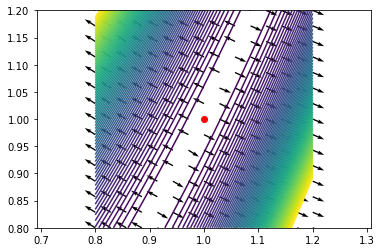

In [2]:
## Solution 
Lambda = 100
f = lambda x,y : ( x - 1)**2 + Lambda*(y - x**2)**2
df = lambda x,y : np.array([4*Lambda*x**3+(2-4*Lambda*y)*x-2, -2*Lambda*(x**2-y)])
ddf = lambda x,y : np.array([[12*Lambda*x**2+2-4*Lambda*y, -4*Lambda*x], [-4*Lambda*x, 2*Lambda]])
HH = lambda x,y : np.linalg.inv(ddf(x,y))

print(f(10,10), df(10,10), ddf(10,10), HH(10,10))

level_lines(f, .8, 1.2, 0.8, 1.2, np.linspace(0, 30, 80))
draw_vector_field(df, .8, 1.2, 0.8, 1.2, 15)
plt.plot(1,1,'or')
plt.axis('equal')
plt.show()

__Question 17.__ Implémentez la méthode de Newton et appliquez-la à la fonction ci-dessus avec $c=0.1$, $\beta=0.75$ et $x^0=(0,0)$. Représentez les itérations sur un graphique et tracez $\ \log(f_\Lambda(x^k))\ $ en fonction de $k$. Commentez les résultats.

_Indication:_ Testez d'abord l'algorithme sur la fonction quadratique ci-dessous.

In [3]:
# Pour le test

#f = lambda x,y : ( x - 1)**2 + 2*(y - 1)**2
#df = lambda x,y : np.array([2*(x - 1) , 4*(y - 1)])
#ddf = lambda x,y : np.array([[2  , 0], [0, 2]])
#HH = lambda x,y : np.array([[.5, 0], [0, .25]])

#pass

[[0.         0.        ]
 [0.23730469 0.        ]
 [0.29950103 0.08583248]
 [0.52165572 0.22107956]
 [0.56433064 0.31664792]
 [0.74396607 0.52041987]
 [0.77759665 0.60352554]
 [0.91362835 0.81592939]
 [0.93178329 0.86789049]
 [0.99578124 0.98748453]
 [0.99810032 0.99619888]
 [0.99999796 0.99999232]
 [1.         1.        ]]


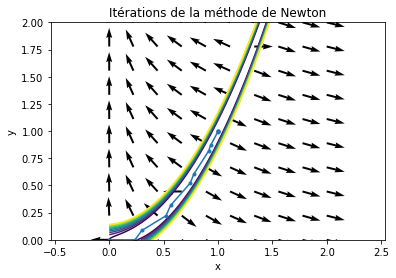

Text(0, 0.5, 'log(f(xk))')

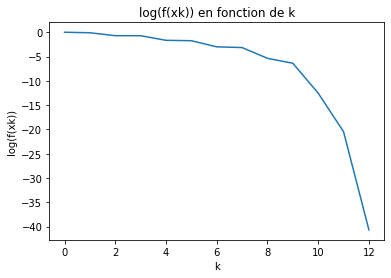

In [4]:
## Parameters
c, beta = .1, .75
epsilon = 1e-8
n_itermax = 200
n_iterlsmax = 20

## initialization 

x0 = np.array([0,0])
f0 = f(x0[0],x0[1])
df0 = df(x0[0],x0[1])
ddf0 = ddf(x0[0],x0[1])
HH0 = HH(x0[0],x0[1])
n_iters = 0

gk = df0
xk = x0
dk = -HH0@df0
newfk = f0
ng0 = np.linalg.norm(df0)
Htrue = [HH0]

W = [x0.tolist()]

#Lambda = 100
#f = lambda x,y : ( x - 1)**2 + Lambda*(y - x**2)**2
#df = lambda x,y : np.array([4*Lambda*x**3+(2-4*Lambda*y)*x-2, -2*Lambda*(x**2-y)])
#ddf = lambda x,y : np.array([[12*Lambda*x**2+2-4*Lambda*y, -4*Lambda*x], [-4*Lambda*x, 2*Lambda]])
#HH = lambda x,y : np.linalg.inv(ddf(x,y))

## Optimization loop

while np.linalg.norm(gk) >= epsilon*ng0 and n_iters <= n_itermax :
    n_iterls = 0
    alpha = 1
    fk = newfk
    newfk = f(xk[0]+alpha*dk[0],xk[1]+alpha*dk[1])
    while newfk >= fk-c*gk@dk*alpha and n_iterls <= n_iterlsmax :
        alpha = beta*alpha
        newfk = f(xk[0]+alpha*dk[0],xk[1]+alpha*dk[1])
        n_iterls += 1
    xk = xk + alpha*dk
    gk = df(xk[0], xk[1])
    Hk = HH(xk[0],xk[1])
    dk = -Hk@gk
    n_iters += 1
    W.append(xk.tolist())
    Htrue.append(Hk.tolist())
    

W = np.array(W)
print(W)
# plot the results 
plt.figure()
plt.plot(W[:,0],W[:,1],'.',linestyle='-')
level_lines(f, 0, 2, 0, 2, np.linspace(1, 3, 10))
draw_vector_field(df, 0 , 2, 0, 2, 10)
plt.axis('equal')
plt.title('Itérations de la méthode de Newton')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# plot of the values of f along the iterations.

plt.plot([k for k in range (n_iters+1)], np.log(f(W[:,0], W[:,1])))
plt.title('log(f(xk)) en fonction de k')
plt.xlabel('k')
plt.ylabel('log(f(xk))')
#plt.plot([k for k in range (n_iters+1)], f(W[:,0], W[:,1]))

In [5]:
W[:,0]

array([0.        , 0.23730469, 0.29950103, 0.52165572, 0.56433064,
       0.74396607, 0.77759665, 0.91362835, 0.93178329, 0.99578124,
       0.99810032, 0.99999796, 1.        ])

La méthode de Newton converge bien vers le minimum de f, et ce en 12 itérations. 
De plus, en traçant $\ \log(f_\Lambda(x^k))\ $ en fonction de $k$, on remarque que $\ \log(f_\Lambda(x^{k+1}))\ $ semble décroitre assez fortement. Cela montre que la convergence de la méthode est très rapide.

In [6]:
log_fk = np.log(f(W[:,0], W[:,1]))
abs(log_fk[1:])/abs(log_fk[:-1])

C:\Users\pierr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


array([       inf, 6.64575526, 1.00811008, 2.32288057, 1.05037209,
       1.72282433, 1.04936472, 1.70285713, 1.18854902, 1.96419329,
       1.63272289, 1.98808085])

<a id='BFGS'></a>
<h2> Une méthode de quasi-Newton (BFGS)</h2>
<hr>

Lorsque le nombre de paramètres est important comme il est habituel en Machine Learning, le calcul des matrices hessiennes $D^2f(x^k)$ et la résolution des systèmes linéaires $D^2f(x^k) d^k=-g^k$ peuvent être trop coûteux. Cependant, il est souvent encore possible d'obtenir une convergence superlinéaire en remplaçant $[D^2f(x^k)]^{-1}$ par une approximation moins gourmande à calculer qu'on notera $H^k$. Il existe plusieurs algorithmes basés sur cette idée. Nous présentons l'une des plus populaires : la méthode BFGS du nom de leurs découvreurs (Broyden, Fletcher, Goldfarb et Shanno).

__Description de la méthode__ : Supposons qu'à l'étape $k$ nous ayons une approximation définie positive symétrique $H^k$ de $\left[D^2f(x^k)\right]^{-1}$. On note $B^k$ son inverse (qui est une approximation de $D^2f(x^k)$). Comme ci-dessus, nous définissons notre direction de descente $d^k$ comme le minimiseur de
$$
f(x^k) + d\cdot \nabla f(x^k) + \dfrac12 d^T B^k d.
$$
Cela conduit à la formule :
$$
d^k = -\left[B^k\right]^{-1} \nabla f(x^k) = - H^k g^k. 
$$

On cherche ensuite $\alpha_k$ satisfaisant (5) par la méthode de ``backtracking", toujours avec $\alpha=1$ et on pose
$$
x^{k+1} := x^k +\alpha_k d^k.
$$

Maintenant, nous avons besoin de calculer approximation $H^{k+1}$ de $\left[D^2f(x^{k+1})\right]^{-1}$. Pour cela, rappelons que nous voulons
$$
\tilde m_{k+1} (d):= f(x^{k+1}) + g^{k+1}\cdot d +\dfrac 12 d^T B^{k+1} d,
$$
soit une approximation de
$$
\overline m_{k+1}(d):= f(x^{k+1} + d).
$$
Nous avons déjà par construction,
$$
\tilde m_{k+1}(0)=\overline m_{k+1}(0)=f(x^{k+1})\qquad\text{et}\qquad \nabla \tilde m_{k +1}(0)=\nabla \overline m_{k+1}(0)=g(x^{k+1}).
$$
Nous appliquons la nouvelle condition
$$
\nabla m_{k+1}(-\tau_k d^k)=\nabla \overline m_{k+1}(-\tau_k d^k)=g^k.
$$

En notant $a^k:=g^{k+1}-g^k$ et $b^k:=\tau^kd^k=x^{k+1}-x^k$, cela équivaut à $B^{k+1}b^k=a^k$. En supposant que $B^{k+1}$ est inversible, cela équivaut à demander que $H^{k+1}$ soit solution de
$$
\tag{6}
Ha^k=b^k.
$$
Une condition nécessaire et suffisante pour que (6) admette une solution symétrique définie positive $H$ est :
$$
\tag{7}
\left<a^k;b^k\right> >0.
$$

Nous ne voulons pas perdre toute l'information déjà contenue dans $H^k$, donc, en supposant que (7) soit vraie, nous choisissons une solution de (6) aussi proche que possible de $H^k$. Un choix populaire consiste à définir :
$$
\tag{8}
H^{k+1} := \left(I-\rho_k b^k\otimes a^k\right) H^k \left(I-\rho_k a^k\otimes b^k\right) + \rho_k b^k\otimes b^k,\quad\text{ avec }\quad \rho_k:=\dfrac1{\left<a^k;b^k\right>}.
$$

__Question 18.__ Vérifiez que la formule (8) donne bien une solution à (6). Vérifiez que $H^{k+1}$ ainsi définie est une matrice symétrique définie positive 

__Question 19.__ Implémentez la méthode BFGS et appliquez-la à la fonction ci-dessus avec $c = 0.1$, $\beta=0.75$ et $x^0=(0,0)$. Comme premier approximation de $D^2f(x^0)$ on prendra $H^0=I$.

Représentez les itérations sur un graphique et tracez $\ \log(f(x^k))\ $ en fonction de $k$. Observez et commentez.

__Question 20.__ Est-ce que $H^k$ converge vers $[D^2 f(x^*)]^{-1}$ ?

[[0.722 0.474]
 [0.474 1.   ]]
[[6.235 6.237]
 [6.237 6.199]]
[[-0.199 -0.299]
 [-0.299 -0.441]]
[[-0.18 -0.28]
 [-0.28 -0.43]]
[[0.069 0.122]
 [0.122 0.215]]
[[0.26  0.36 ]
 [0.36  0.504]]
[[0.103 0.152]
 [0.152 0.227]]
[[0.071 0.106]
 [0.106 0.163]]
[[0.267 0.406]
 [0.406 0.617]]
[[0.117 0.186]
 [0.186 0.297]]
[[0.069 0.111]
 [0.111 0.181]]
[[0.266 0.461]
 [0.461 0.803]]
[[0.263 0.475]
 [0.475 0.861]]
[[0.379 0.711]
 [0.711 1.34 ]]
[[0.376 0.728]
 [0.728 1.415]]
[[0.457 0.901]
 [0.901 1.784]]
[[0.492 0.98 ]
 [0.98  1.955]]
[[0.52  1.039]
 [1.039 2.078]]
[[0.506 1.011]
 [1.011 2.024]]
[[0.5   0.999]
 [0.999 2.003]]
[[0.5   0.999]
 [0.999 2.003]]


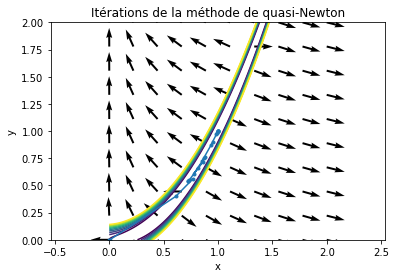

Text(0, 0.5, 'log(f(xk))')

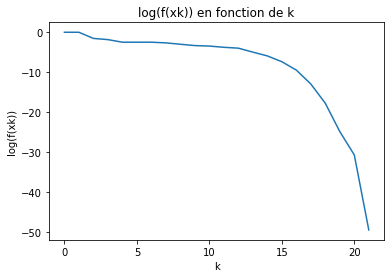

In [7]:
## Solution

#Fonction pour calculer les Hk

def HH(a,b,H) :
    p = 1/(a.T@b)
    return (np.eye(2)-p*np.tensordot(b,a,axes=0))@H@(np.eye(2)-p*np.tensordot(a,b,axes=0))+p*np.tensordot(b,b,axes=0)
'HH = lambda a,b,H : (np.eye(2)-(1/(a.T@b))*b@a.T)@H@(np.eye(2)-(1/(a.T@b))*a@b.T)+(1/(a.T@b))*b@b.T'

## Parameters
c, beta = .1, .75
epsilon = 1e-8
itermax = 200
iter_ls_max = 40

##
np.set_printoptions(precision=3)
np.set_printoptions(suppress="True")

## initialization 

x0 = np.array([0,0])
f0 = f(x0[0],x0[1])
g0 = df(x0[0],x0[1])
ng0 = np.linalg.norm(g0)
H0 = np.eye(2)
n_iters = 0

gk = g0
xk = x0
dk = -H0@g0
fk = f0
Hk = H0
Happrox = [H0]

W = [x0.tolist()]

## Optimization loop

while np.linalg.norm(gk) >= epsilon*ng0 and n_iters <= n_itermax :
    n_iterls = 0
    alpha = 1
    fk = newfk
    newfk = f(xk[0]+alpha*dk[0],xk[1]+alpha*dk[1])
    while newfk >= fk-c*gk@dk*alpha and n_iterls <= n_iterlsmax :
        alpha = beta*alpha
        newfk = f(xk[0]+alpha*dk[0],xk[1]+alpha*dk[1])
        n_iterls += 1
    xk = xk + alpha*dk
    ak = df(xk[0], xk[1]) - gk
    bk = alpha*dk
    gk = df(xk[0], xk[1])
    Hk = HH(ak, bk, Hk)
    Happrox.append(Hk.tolist())
    dk = -Hk@gk
    n_iters += 1
    W.append(xk.tolist())
    print(Hk)
    
W = np.array(W)
# plot the results 
plt.figure()
plt.plot(W[:,0],W[:,1],'.',linestyle='-')
level_lines(f, 0, 2, 0, 2, np.linspace(1, 3, 10))
draw_vector_field(df, 0 , 2, 0, 2, 10)
plt.axis('equal')
plt.title('Itérations de la méthode de quasi-Newton')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# plot of the values of f along the iterations.
plt.plot([k for k in range (n_iters+1)], np.log(f(W[:,0], W[:,1])))
plt.title('log(f(xk)) en fonction de k')
plt.xlabel('k')
plt.ylabel('log(f(xk))')

# plot of the values of ||Happrox-Htrue|| along the iterations.


La méthode BFGS permet également de converger. Le nombre d'itérations nécessaire est cependant plus important que pour la méthode de Newton, la convergence de cette méthode est donc moins rapide, elle est moins efficace. Cela est logique étant donné que l'objectif principal est de réduire le coût de calcul de l'inverse des matrices en en calculant une estimation, qui donnera forcément des résultats moins précis.

Text(0, 0.5, '||Happrox-Htrue||')

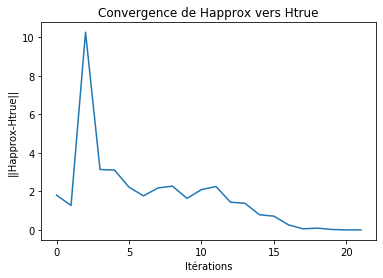

In [8]:
HH = lambda x,y : np.linalg.inv(ddf(x,y))
Htrue = HH(1,1)
X = np.array([np.linalg.norm(H-Htrue) for H in Happrox])
plt.plot(X)
plt.title('Convergence de Happrox vers Htrue')
plt.xlabel('Itérations')
plt.ylabel('||Happrox-Htrue||')

Happrox converge bien vers Htrue, avec une différence cohérente par rapport aux graphiques précédents.